# Course-End Project: Employee Turnover Analytics

### Project Statement:
Portobello Tech is an app innovator that has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details including the number of projects they worked upon, average monthly working hours, time spent in the company, promotions in the last 5 years, and salary level.
Data from prior evaluations show the employee’s satisfaction at the workplace. The data could be used to identify patterns in work style and their interest to continue to work in the company. 
The HR Department owns the data and uses it to predict employee turnover. Employee turnover refers to the total number of workers who leave a company over a certain time period.
As the ML Developer assigned to the HR Department, you have been asked to create ML Programs to
1.	Perform data quality check by checking for missing values if any.
2.	Understand what factors contributed most to employee turnover by EDA.
3.	Perform clustering of Employees who left based on their satisfaction and evaluation.
4.	Handle the left Class Imbalance using SMOTE technique.
5.	Perform k-fold cross-validation model training and evaluate performance. 
6.	Identify the best model and justify the evaluation metrics used. 
7.	Suggest various retention strategies for targeted employees.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

In [3]:
# Load the data
hr_data = pd.read_excel('1688640705_hr_comma_sep.xlsx', sheet_name='HR_comma_sep', header=0)
hr_data.head() # Display the first few rows of the dataset

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


As we can see Department column header does not appear, instead we see the word "sales". Let's change this header column

In [4]:
# Rename the 'sales' column to 'Department'
hr_data.rename(columns={'sales': 'department','Work_accident': 'work_accident'}, inplace=True) # Also, renaming 'Work_accident' to 'work_accident'


### 1. Null Values
Now, let's review whether there are null values and the data type of each column. 

In [5]:
hr_data.info() # Check the data types and non-null counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


There are no null values present in the dataset! And the data types look ok. Only we should highlight that `work_accident`, `left` and `promotion_last_5years` are categorical variables but they are already in binary format. For `department` and `salary`, which are also categorical, we'll get dummy variables for them.

### 2. EDA
#### 2.1 Before proceeding with the one-hot encoding of categorical features, let's first investigate the distribution of features and the correlation between them.

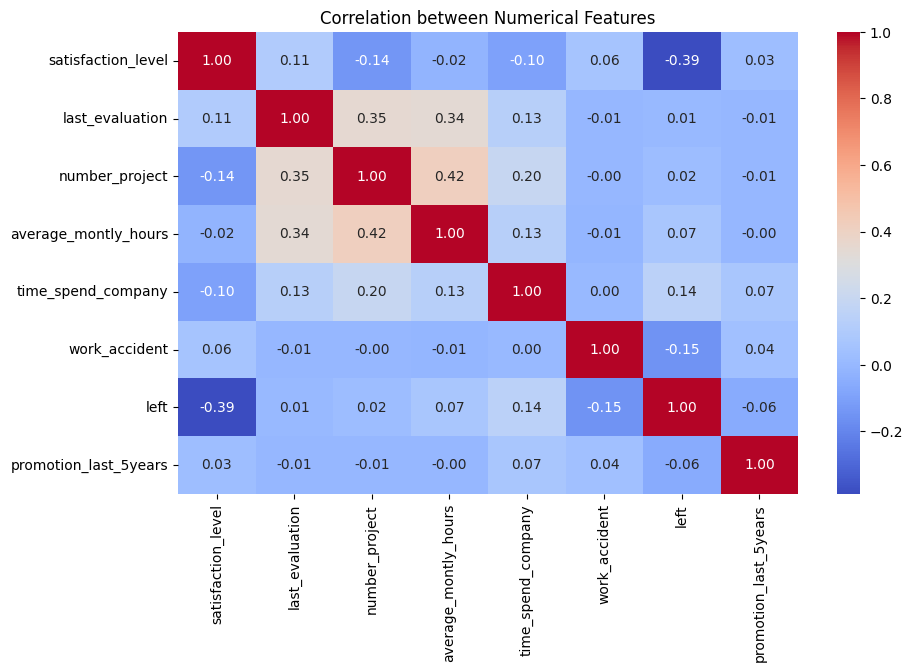

In [6]:
num_features = hr_data.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(hr_data[num_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
plt.title('Correlation between Numerical Features')
plt.show()

From this correlation matrix we can take the following highlights:
1. The strongest correlation identified within the dataset (0.42) is between `number_project` and `average_monthly_hours` and this is a moderate correlation. This is undestandable as having more project to look after results in higher workload, thus more worked hours.
2. The strongest negative correlation identified (-0.39) was between `satisfaction_level` and `left`. This is a moderate correlation. It indicates that the lower the satisfaction level is, the more likely it is that the employee will leave the company.

#### 2.2 Let's know plot the distribution of Employee Satisfaction, Employee Evaluation and Average Monthly Hours Worked 

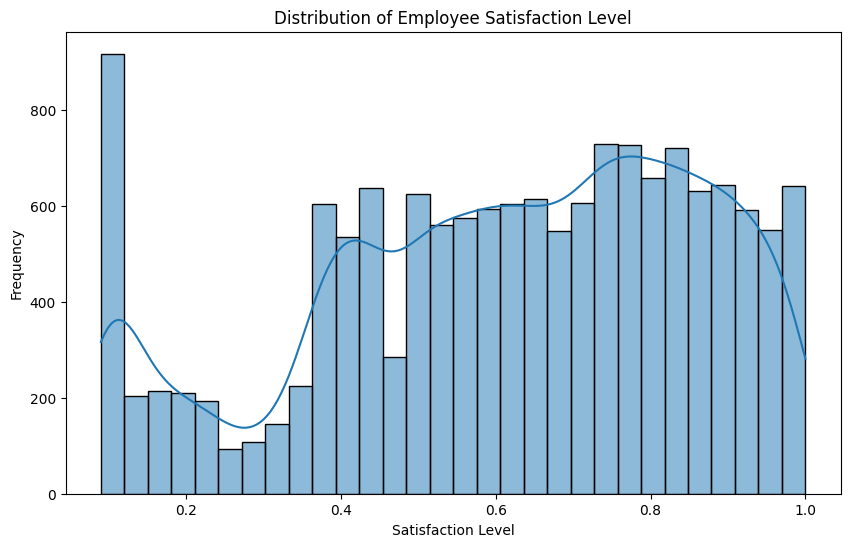

In [7]:
# Draw the distribution plot of Employee Satisfaction
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(hr_data['satisfaction_level'], kde=True, ax=ax)
plt.title('Distribution of Employee Satisfaction Level')
plt.xlabel('Satisfaction Level')
plt.ylabel('Frequency')
plt.show()

There is a good portion of the employees rating high satisfaction. However, there is a BIG peak of extreamely low satisfaction

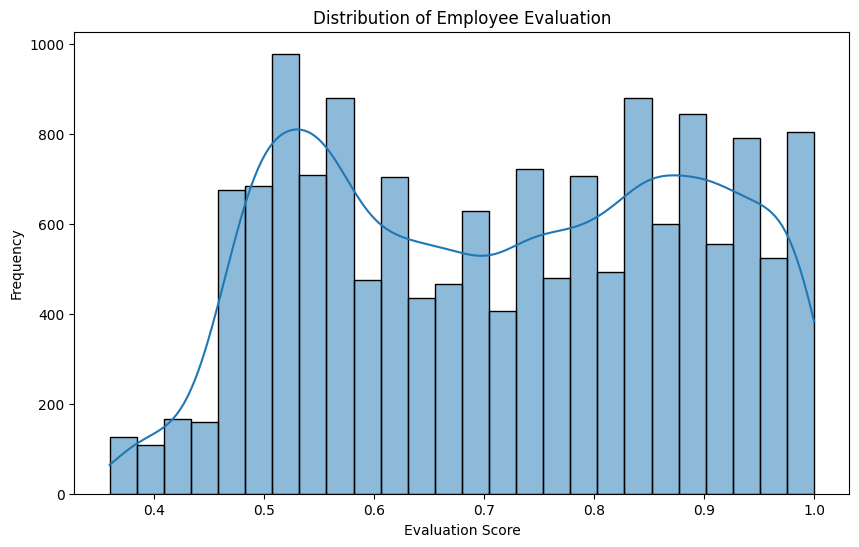

In [15]:
# Draw the distribution plot of Employee Evaluation
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(hr_data['last_evaluation'], kde=True, ax=ax)
plt.title('Distribution of Employee Evaluation')
plt.xlabel('Evaluation Score')
plt.ylabel('Frequency')
plt.show()

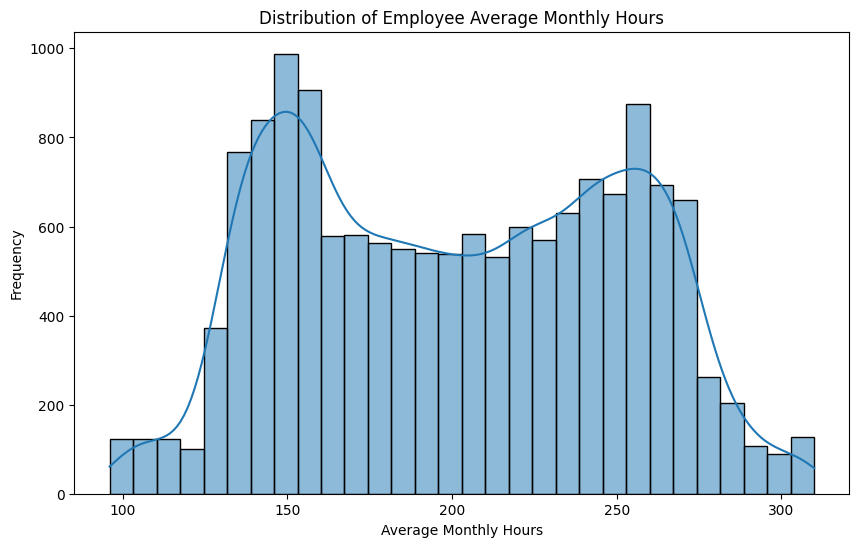

In [16]:
# Draw the distribution plot of Employee Average Monthly Hours
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(hr_data['average_montly_hours'], kde=True, ax=ax)
plt.title('Distribution of Employee Average Monthly Hours')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Frequency')
plt.show()


Looks like we probably have 2 main group of employees, one working ~150 hour on avarage every month and the other working +250 hours monthly!!!

#### 2.3 Let's now plot the bar plot of Employee Project Count of both employees who left and who stayed in the organization

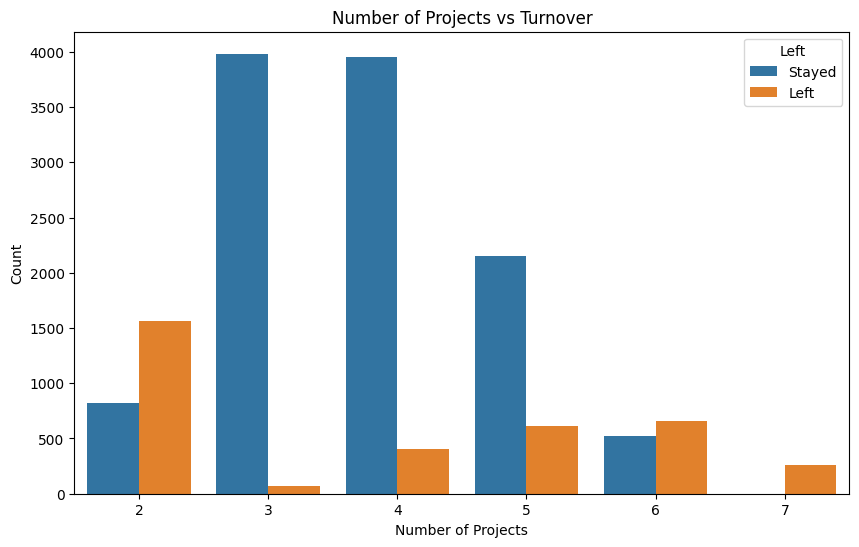

In [25]:
# Draw the bar plot of Employee Project Count of both employees who left and who stayed in the organization
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='number_project', hue='left', data=hr_data)
plt.title('Number of Projects vs Turnover')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.legend(title='Left', labels=['Stayed', 'Left'])
plt.show()

#### Highlights

There are 3 main behaviors here:

* Having 2 projects represents a high change for turnover. Probably suggestiong a feeling of underutilized by the employees
* The optimum number of projects handle by employees is 3 to 4, where turnover rate is minimun. For employees with 5 projects, this rate starts to increase considerably.
* Having 6 or 7 projects may represent an excesive workload, resulting in a very high turnover rate.


T H O U G H T S

Workload Balance: It's crucial for management to balance the number of projects assigned to employees. Ensuring that employees are neither underworked nor overworked can help in maintaining high retention rates.


Employee Engagement: For employees with fewer projects, consider strategies to increase engagement, like offering professional development opportunities or involving them in more challenging tasks.


Preventing Burnout: For those with a high number of projects, it's important to monitor their workload and provide support to prevent burnout, such as flexible work arrangements or additional resources.

It is also important to consider that personalized workloads and development opportunities can further improve employee satisfaction and thus, employee retention. 

### 3 Employee Classification Through CLustering Analysis


Let's use unsupervised learning clustering method to determine employee classification. For this, we'll use 3 features:
* Employee Satisfaction
* Last Evaluation
* Left

Let's make 3 clusters of those employees who left the company.

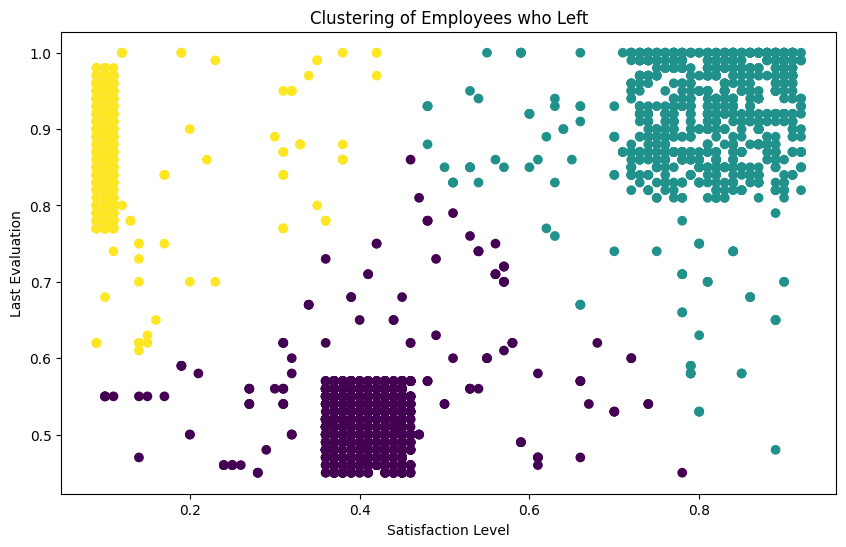

In [22]:

# Perform clustering of Employees who left based on their satisfaction and evaluation
left_data = hr_data[hr_data['left'] == 1][['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(left_data)
left_data['cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(left_data['satisfaction_level'], left_data['last_evaluation'], c=left_data['cluster'], cmap='viridis')
plt.title('Clustering of Employees who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()


 H I G H L I G H T S

 * High Evaluation, Low Satisfaction (Yellow Cluster):

Characteristics: Employees in this cluster have high evaluation scores (around 0.8 to 1.0) but low satisfaction levels (below 0.3).
Implications: Despite performing well, these employees might have left due to dissatisfaction with their work environment, compensation, or other non-performance-related factors. This suggests that high performance does not necessarily equate to high retention if satisfaction is low.



* Low Evaluation, Low Satisfaction (Purple Cluster):

Characteristics: This cluster shows employees with both low evaluation scores (around 0.5 to 0.6) and low satisfaction levels (below 0.4).
Implications: These employees might have left due to poor performance coupled with dissatisfaction. This group highlights the importance of addressing both performance and satisfaction to improve retention.



* High Evaluation, High Satisfaction (Dark Cyan Cluster):

Characteristics: Employees here have high evaluation scores (above 0.7) and high satisfaction levels (above 0.6).
Implications: Despite having high satisfaction and evaluation scores, these employees have still left the company. This could indicate external factors influencing their decision to leave, such as better opportunities elsewhere or personal reasons.

### 4 Class Imbalance - SMOTE

As is natural, this is a umbalance problem - proportion of employees who left the company is smaller than the employees staying. Thus, it's necessary to apply  technics to reduce staying employees' influence on the models we'll build. SMOTE technic will be used after creating dummy variables for categorical features.

In [26]:
# Handle the left Class Imbalance using SMOTE technique
# Pre-Process the data by converting categorical columns to numerical columns
data = pd.get_dummies(hr_data, columns=['department', 'salary'], drop_first=True)

# Separate features and target variable
X = data.drop('left', axis=1)
y = data['left']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Upsample the train dataset using SMOTE technique
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


### 5 Let's finally feed ML models with our prepared data

 We'll try models:
* Logistic Regression
* Random Forest Classifier
* Gradient Boosting Classifier

5-Fol cross-validation will be use for fine-tuning.

In [ ]:
# Train a Logistic Regression model and apply a 5-Fold CV and plot the classification report
log_reg = LogisticRegression()
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
log_reg_scores = cross_val_score(log_reg, X_train_smote, y_train_smote, cv=cv, scoring='f1')
log_reg.fit(X_train_smote, y_train_smote)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

c:\Users\omunozsanchez\OneDrive - Deloitte (O365D)\Documents\Trainings\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\omunozsanchez\OneDrive - Deloitte (O365D)\Documents\Trainings\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2286
           1       0.50      0.75      0.60       714

    accuracy                           0.76      3000
   macro avg       0.70      0.76      0.72      3000
weighted avg       0.81      0.76      0.78      3000



c:\Users\omunozsanchez\OneDrive - Deloitte (O365D)\Documents\Trainings\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\omunozsanchez\OneDrive - Deloitte (O365D)\Documents\Trainings\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

Let's consider that employee retention is a key factor for company success. Thus, recall (out of all employees, who actually left the company) is going to be our important metric (though F1 score can also be consider for more comprenhensive evaluation). 


Classification report for Logistic Regression returns a 0.75 recall - not a bad score, but let's try with our other options.

In [30]:
# Train a Random Forest Classifier model and apply the 5-Fold CV and plot the classification report
rf_clf = RandomForestClassifier(random_state=123)
rf_scores = cross_val_score(rf_clf, X_train_smote, y_train_smote, cv=cv, scoring='f1')
rf_clf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



Random Forest definitly outperforms logistic regression by far - 0.98 recall!


In [32]:

# Train a Gradient Boosting Classifier model and apply the 5-Fold CV and plot the classification report
gb_clf = GradientBoostingClassifier(random_state=123)
gb_scores = cross_val_score(gb_clf, X_train_smote, y_train_smote, cv=cv, scoring='f1')
gb_clf.fit(X_train_smote, y_train_smote)
y_pred_gb = gb_clf.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.92      0.93      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.97      0.97      0.97      3000



Gradient Booting classifier also performs very well classsifying chrun, however random forest stays the best.



### 6 ROC/AUC

Additionally, we can plot ROC/AUC to confirm model performance:

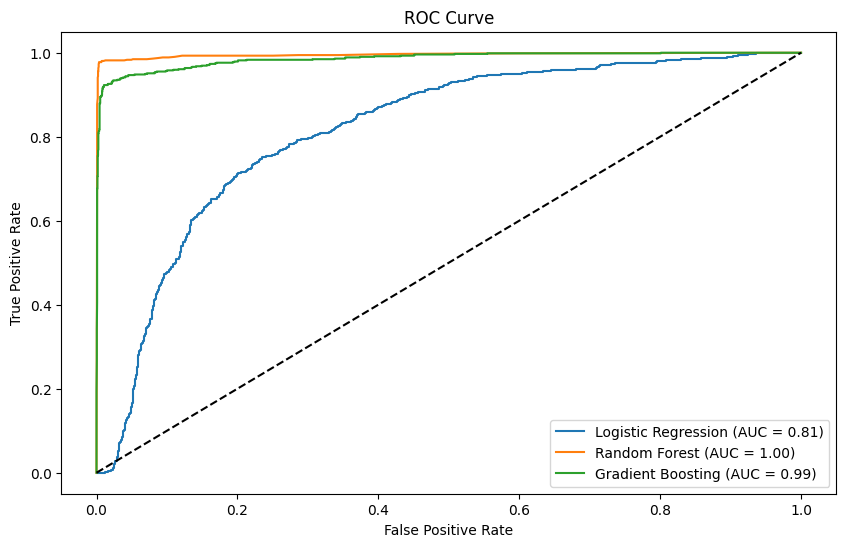

In [34]:
# Identify the best model and justify the evaluation metrics used
# Find the ROC/AUC for each model and plot the ROC curve
models = [log_reg, rf_clf, gb_clf]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
plt.figure(figsize=(10, 6))
for model, name in zip(models, model_names):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

As stated, Random Forest outperforms the other two!!


And finally, let's show confusion matrix to have another easy way to see the difference between model performance:

In [35]:
# Find the confusion matrix for each of the models
for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {name}:')
    print(cm)


Confusion Matrix for Logistic Regression:
[[1753  533]
 [ 180  534]]
Confusion Matrix for Random Forest:
[[2270   16]
 [  16  698]]
Confusion Matrix for Gradient Boosting:
[[2232   54]
 [  49  665]]


### 7 Retention Strategies

Let's predict turnover in our test set using our best model: Random Forest.


After, using probability of predicted data points (probability of leaving the company), let's create an strategy suggestion. This strategy will follow the criteria:

* Safe Zone (Green) (Score < 20%)
* Low Risk Zone (Yellow) (20% < Score < 60%)
* Medium Risk Zone (Orange) (60% < Score < 90%)
* High Risk Zone (Red) (Score > 90%).


In [39]:
best_model = rf_clf  
y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]

# Categorize the employees into four zones and suggest retention strategies
zones = pd.cut(y_pred_prob_best, bins=[0, 0.2, 0.6, 0.9, 1], labels=['Safe Zone', 'Low Risk', 'Moderate Risk', 'High Risk'],include_lowest=True)
retention_strategies = {
    'Safe Zone': 'Continue current engagement practices.',
    'Low Risk': 'Monitor satisfaction levels and provide feedback.',
    'Moderate Risk': 'Implement targeted retention programs and career development opportunities.',
    'High Risk': 'Conduct stay interviews and address key concerns immediately.'
}

# Print the retention strategies for each zone
for zone in zones.unique():
    print(f'Retention Strategy for {zone}: {retention_strategies[zone]}')


Retention Strategy for Safe Zone: Continue current engagement practices.
Retention Strategy for Low Risk: Monitor satisfaction levels and provide feedback.
Retention Strategy for High Risk: Conduct stay interviews and address key concerns immediately.
Retention Strategy for Moderate Risk: Implement targeted retention programs and career development opportunities.


And these are the different zone sizes which corresponds to the strategis above:

In [43]:
zones.value_counts()

Safe Zone        2179
Low Risk          117
Moderate Risk      57
High Risk         647
Name: count, dtype: int64